In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from itertools import product
import utils as ut
reload(ut)
%matplotlib inline
%config InlineBackend.figure_formats=['svg']

In [42]:
train = pd.read_csv('data/full_train.csv', index_col=0)
val = pd.read_csv('data/full_val.csv', index_col=0)
test = pd.read_csv('data/full_test.csv', index_col=0)

In [43]:
# Separate target variables
X, y_e, y_a = train.ix[:, :-3], train.ix[:, 'elevation'], train.ix[:, 'azimuth']
X_val, y_val_e, y_val_a = val.ix[:, :-3], val.ix[:, 'elevation'], val.ix[:, 'azimuth']
X_test, y_test_e, y_test_a = test.ix[:, :-3], test.ix[:, 'elevation'], test.ix[:, 'azimuth']

In [44]:
print X.shape, X_val.shape, X_test.shape

(42500, 648) (6250, 648) (7500, 648)


### Standarize features

In [7]:
scaler = preprocessing.StandardScaler().fit(X)

In [8]:
# Feature normalization
X = scaler.transform(X)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [9]:
standard_train = pd.concat([pd.DataFrame(X, index=train.index), y_e, y_a, train.subject_id], axis=1)
standard_val = pd.concat([pd.DataFrame(X_val, index=val.index), y_val_e, y_val_a, val.subject_id], axis=1)
standard_test = pd.concat([pd.DataFrame(X_test, index=test.index), y_test_e, y_test_a, test.subject_id], axis=1)

In [10]:
print standard_train.shape
print standard_val.shape
print standard_test.shape

(42500, 651)
(6250, 651)
(7500, 651)


In [32]:
# Write .csv for each set
standard_train.to_csv('data/full_standarized_train.csv')
standard_val.to_csv('data/full_standarized_val.csv')
standard_test.to_csv('data/full_standarized_test.csv')

### Grid Search method

In [54]:
def grid_search(X, y, X_val, y_val, loss_func, model_grid):
    res = {}
    for j in range(len(model_grid)):
        tested_params = []
        loss_val_res = []
        loss_train_res = []
        skmodel = model_grid[j]['model']
        params_to_test = model_grid[j]["params"]

        for param_comb in product(*params_to_test.values()):
            params = {}
            for i, p in enumerate(params_to_test.keys()):
                params[p] = param_comb[i]
            print 'Testing j:', j, 'param_comb:', params
            model = skmodel(**params)
            model.fit(X, y)
            y_pred = model.predict(X_val)
            y_pred_train = model.predict(X)
            loss = loss_func(y_pred, y_val)
            loss_train = loss_func(y_pred_train, y)
            tested_params.append(str(params))
            loss_val_res.append(loss)
            loss_train_res.append(loss_train)
        print j, str(skmodel), zip(tested_params, loss_train_res, loss_val_res)
        res[str(skmodel)] = {p: [l_t, l_v] for (p, l_t, l_v) in zip(tested_params, loss_train_res, loss_val_res)}
    return res

def grid_search_class(X, y, X_val, y_val, loss_func, model_grid):
    res = {}
    for j in range(len(model_grid)):
        tested_params = []
        loss_val_res = []
        loss_train_res = []
        skmodel = model_grid[j]['model']
        params_to_test = model_grid[j]["params"]

        for param_comb in product(*params_to_test.values()):
            params = {}
            for i, p in enumerate(params_to_test.keys()):
                params[p] = param_comb[i]
            print 'Testing j:', j, 'param_comb:', params
            model = skmodel(**params)
            model.fit(X, y.astype(np.str))
            y_pred = model.predict(X_val).astype(np.float64)
            y_pred_train = model.predict(X).astype(np.float64)
            loss = loss_func(y_pred, y_val)
            loss_train = loss_func(y_pred_train, y)
            tested_params.append(str(params))
            loss_val_res.append(loss)
            loss_train_res.append(loss_train)
        print j, str(skmodel), zip(tested_params, loss_train_res, loss_val_res)
        res[str(skmodel)] = {p: [l_t, l_v] for (p, l_t, l_v) in zip(tested_params, loss_train_res, loss_val_res)}
    return res

In [55]:
model_grid = [{
            "model": DecisionTreeClassifier,
            "params": {'max_depth': range(7, 9),
                       'min_samples_leaf': [1, 100],
                       'min_samples_split': [2, 100]}
            },
            {
            "model": RandomForestClassifier,
            "params": {'n_estimators': [50, 100],
                       'max_leaf_nodes': [240, None],
                       'max_features': ['sqrt', 'log2']}
            }]

print 'Classification Azimuth'
print grid_search_class(X, y_a, X_val, y_val_a, ut.loss_azimuth, model_grid)

Classification Azimuth
Testing j: 0 param_comb: {'min_samples_split': 2, 'max_depth': 7, 'min_samples_leaf': 1}
Testing j: 0 param_comb: {'min_samples_split': 2, 'max_depth': 7, 'min_samples_leaf': 100}
Testing j: 0 param_comb: {'min_samples_split': 2, 'max_depth': 8, 'min_samples_leaf': 1}
Testing j: 0 param_comb: {'min_samples_split': 2, 'max_depth': 8, 'min_samples_leaf': 100}
Testing j: 0 param_comb: {'min_samples_split': 100, 'max_depth': 7, 'min_samples_leaf': 1}
Testing j: 0 param_comb: {'min_samples_split': 100, 'max_depth': 7, 'min_samples_leaf': 100}
Testing j: 0 param_comb: {'min_samples_split': 100, 'max_depth': 8, 'min_samples_leaf': 1}
Testing j: 0 param_comb: {'min_samples_split': 100, 'max_depth': 8, 'min_samples_leaf': 100}
0 <class 'sklearn.tree.tree.DecisionTreeClassifier'> [("{'min_samples_split': 2, 'max_depth': 7, 'min_samples_leaf': 1}", 16.96294117647059, 16.0392), ("{'min_samples_split': 2, 'max_depth': 7, 'min_samples_leaf': 100}", 17.18435294117647, 16.1744),

In [68]:

model_grid = [
            {
            "model": Lasso,
            "params": {'normalize': [True],
                       'alpha': [0.00001, 0.0001, 0.001]}
            },
            {
            "model": DecisionTreeRegressor,
            "params": {'max_depth': range(10, 12),
                       'min_samples_leaf': [1, 100],
                       'min_samples_split': [2, 100]}
            },
            {
            "model": RandomForestRegressor,
            "params": {'n_estimators': [50, 100],
                       'max_leaf_nodes': [240, None],
                       'max_features': ['sqrt', 'log2']}
            },
            {
            "model": GradientBoostingRegressor,
            "params": {'loss': ['lad', 'huber'],
                       'n_estimators': [80, 120],
                       'subsample': [0.8, 1],
                       'max_leaf_nodes': [6, 9],
                       'max_features': [None, 'sqrt', 'log2']}
            }]

print 'Regression Azimuth'
print grid_search(X, y_a, X_val, y_val_a, ut.loss_azimuth, model_grid)

Regression Azimuth
Testing j: 0 param_comb: {'normalize': True, 'alpha': 1e-05}
Testing j: 0 param_comb: {'normalize': True, 'alpha': 0.0001}
Testing j: 0 param_comb: {'normalize': True, 'alpha': 0.001}
0 <class 'sklearn.linear_model.coordinate_descent.Lasso'> [("{'normalize': True, 'alpha': 1e-05}", 37.10725940905805, 51.13799636987498), ("{'normalize': True, 'alpha': 0.0001}", 37.16808937995028, 44.04938151007742), ("{'normalize': True, 'alpha': 0.001}", 37.681744721517866, 38.91965033497008)]
{"<class 'sklearn.linear_model.coordinate_descent.Lasso'>": {"{'normalize': True, 'alpha': 1e-05}": [37.10725940905805, 51.13799636987498], "{'normalize': True, 'alpha': 0.0001}": [37.16808937995028, 44.04938151007742], "{'normalize': True, 'alpha': 0.001}": [37.681744721517866, 38.91965033497008]}}


In [57]:
model_grid = [{
            "model": DecisionTreeClassifier,
            "params": {'max_depth': range(11, 13),
                       'min_samples_leaf': [1, 100],
                       'min_samples_split': [2, 100]}
            },
            {
            "model": RandomForestClassifier,
            "params": {'n_estimators': [50, 100],
                       'max_leaf_nodes': [128, None],
                       'max_features': ['sqrt', 'log2']}
            }]

print 'Classification elevation'
print grid_search_class(X, y_e, X_val, y_val_e, mean_absolute_error, model_grid)

Classification elevation
Testing j: 0 param_comb: {'min_samples_split': 2, 'max_depth': 11, 'min_samples_leaf': 1}
Testing j: 0 param_comb: {'min_samples_split': 2, 'max_depth': 11, 'min_samples_leaf': 100}
Testing j: 0 param_comb: {'min_samples_split': 2, 'max_depth': 12, 'min_samples_leaf': 1}
Testing j: 0 param_comb: {'min_samples_split': 2, 'max_depth': 12, 'min_samples_leaf': 100}
Testing j: 0 param_comb: {'min_samples_split': 100, 'max_depth': 11, 'min_samples_leaf': 1}
Testing j: 0 param_comb: {'min_samples_split': 100, 'max_depth': 11, 'min_samples_leaf': 100}
Testing j: 0 param_comb: {'min_samples_split': 100, 'max_depth': 12, 'min_samples_leaf': 1}
Testing j: 0 param_comb: {'min_samples_split': 100, 'max_depth': 12, 'min_samples_leaf': 100}
0 <class 'sklearn.tree.tree.DecisionTreeClassifier'> [("{'min_samples_split': 2, 'max_depth': 11, 'min_samples_leaf': 1}", 10.855058823529411, 17.613900000000001), ("{'min_samples_split': 2, 'max_depth': 11, 'min_samples_leaf': 100}", 13.7

In [62]:
model_grid = [{
            "model": DecisionTreeRegressor,
            "params": {'max_depth': range(10, 13),
                       'min_samples_leaf': [1, 100],
                       'min_samples_split': [2, 100]}
            },
            {
            "model": RandomForestRegressor,
            "params": {'n_estimators': [50, 100],
                       'max_leaf_nodes': [128, None],
                       'max_features': ['sqrt', 'log2']}
            },
            {
            "model": GradientBoostingRegressor,
            "params": {'loss': ['lad', 'huber'],
                       'n_estimators': [80, 120],
                       'subsample': [0.8, 1],
                       'max_leaf_nodes': [6, 9],
                       'max_features': [None, 'sqrt', 'log2']}
            }]

print 'Regression elevation'
print grid_search(X, y_e, X_val, y_val_e, mean_absolute_error, model_grid)

Regression elevation
Testing j: 0 param_comb: {'min_samples_split': 2, 'max_depth': 10, 'min_samples_leaf': 1}
Testing j: 0 param_comb: {'min_samples_split': 2, 'max_depth': 10, 'min_samples_leaf': 100}
Testing j: 0 param_comb: {'min_samples_split': 2, 'max_depth': 11, 'min_samples_leaf': 1}
Testing j: 0 param_comb: {'min_samples_split': 2, 'max_depth': 11, 'min_samples_leaf': 100}
Testing j: 0 param_comb: {'min_samples_split': 2, 'max_depth': 12, 'min_samples_leaf': 1}
Testing j: 0 param_comb: {'min_samples_split': 2, 'max_depth': 12, 'min_samples_leaf': 100}
Testing j: 0 param_comb: {'min_samples_split': 100, 'max_depth': 10, 'min_samples_leaf': 1}
Testing j: 0 param_comb: {'min_samples_split': 100, 'max_depth': 10, 'min_samples_leaf': 100}
Testing j: 0 param_comb: {'min_samples_split': 100, 'max_depth': 11, 'min_samples_leaf': 1}
Testing j: 0 param_comb: {'min_samples_split': 100, 'max_depth': 11, 'min_samples_leaf': 100}
Testing j: 0 param_comb: {'min_samples_split': 100, 'max_dept

## Building models with training and validation data with best hyper-parameters

In [64]:
X_big = pd.concat([X, X_val], axis=0)
y_big_e = pd.concat([y_e, y_val_e], axis=0)
y_big_a = pd.concat([y_a, y_val_a], axis=0)

In [67]:
model_grid = [ {
            "model": Lasso,
            "params": {'normalize': [True],
                       'alpha': [0.001]}
            },
            {
            "model": DecisionTreeRegressor,
            "params": {'max_depth': [11],
                       'min_samples_leaf': [100],
                       'min_samples_split': [2]}
            },
            {
            "model": RandomForestRegressor,
            "params": {'n_estimators': [100],
                       'max_leaf_nodes': [None],
                       'max_features': ['sqrt']}
            },
            {
            "model": GradientBoostingRegressor,
            "params": {'loss': ['huber'],
                       'n_estimators': [120],
                       'subsample': [1],
                       'max_leaf_nodes': [9],
                       'max_features': [None]}
            }]

print 'Regression elevation'
print grid_search(X_big, y_big_e, X_test, y_test_e, mean_absolute_error, model_grid)

Regression elevation
Testing j: 0 param_comb: {'normalize': True, 'alpha': 0.001}
0 <class 'sklearn.linear_model.coordinate_descent.Lasso'> [("{'normalize': True, 'alpha': 0.001}", 15.256297617074402, 15.736538227215414)]
Testing j: 1 param_comb: {'min_samples_split': 2, 'max_depth': 11, 'min_samples_leaf': 100}
1 <class 'sklearn.tree.tree.DecisionTreeRegressor'> [("{'min_samples_split': 2, 'max_depth': 11, 'min_samples_leaf': 100}", 12.648313934172737, 14.963513324473395)]
Testing j: 2 param_comb: {'n_estimators': 100, 'max_leaf_nodes': None, 'max_features': 'sqrt'}
2 <class 'sklearn.ensemble.forest.RandomForestRegressor'> [("{'n_estimators': 100, 'max_leaf_nodes': None, 'max_features': 'sqrt'}", 2.5702015384615389, 11.03241)]
Testing j: 3 param_comb: {'n_estimators': 120, 'loss': 'huber', 'subsample': 1, 'max_features': None, 'max_leaf_nodes': 9}
3 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'> [("{'n_estimators': 120, 'loss': 'huber', 'subsample': 1, 'max_fea

In [69]:
model_grid = [{
            "model": DecisionTreeClassifier,
            "params": {'max_depth': [11],
                       'min_samples_leaf': [1],
                       'min_samples_split': [2]}
            },
            {
            "model": RandomForestClassifier,
            "params": {'n_estimators': [100],
                       'max_leaf_nodes': [None],
                       'max_features': ['sqrt']}
            }]

print 'Classification elevation'
print grid_search_class(X_big, y_big_e, X_test, y_test_e, mean_absolute_error, model_grid)

Classification elevation
Testing j: 0 param_comb: {'min_samples_split': 2, 'max_depth': 11, 'min_samples_leaf': 1}
0 <class 'sklearn.tree.tree.DecisionTreeClassifier'> [("{'min_samples_split': 2, 'max_depth': 11, 'min_samples_leaf': 1}", 11.057307692307692, 15.105)]
Testing j: 1 param_comb: {'n_estimators': 100, 'max_leaf_nodes': None, 'max_features': 'sqrt'}
1 <class 'sklearn.ensemble.forest.RandomForestClassifier'> [("{'n_estimators': 100, 'max_leaf_nodes': None, 'max_features': 'sqrt'}", 0.0, 10.134)]
{"<class 'sklearn.ensemble.forest.RandomForestClassifier'>": {"{'n_estimators': 100, 'max_leaf_nodes': None, 'max_features': 'sqrt'}": [0.0, 10.134]}, "<class 'sklearn.tree.tree.DecisionTreeClassifier'>": {"{'min_samples_split': 2, 'max_depth': 11, 'min_samples_leaf': 1}": [11.057307692307692, 15.105]}}


In [70]:
model_grid = [{
            "model": DecisionTreeClassifier,
            "params": {'max_depth': [7],
                       'min_samples_leaf': [1],
                       'min_samples_split': [100]}
            },
            {
            "model": RandomForestClassifier,
            "params": {'n_estimators': [100],
                       'max_leaf_nodes': [None],
                       'max_features': ['sqrt']}
            }]

print 'Classification Azimuth'
print grid_search_class(X_big, y_big_a, X_test, y_test_a, ut.loss_azimuth, model_grid)

Classification Azimuth
Testing j: 0 param_comb: {'min_samples_split': 100, 'max_depth': 7, 'min_samples_leaf': 1}
0 <class 'sklearn.tree.tree.DecisionTreeClassifier'> [("{'min_samples_split': 100, 'max_depth': 7, 'min_samples_leaf': 1}", 16.5, 17.298666666666666)]
Testing j: 1 param_comb: {'n_estimators': 100, 'max_leaf_nodes': None, 'max_features': 'sqrt'}
1 <class 'sklearn.ensemble.forest.RandomForestClassifier'> [("{'n_estimators': 100, 'max_leaf_nodes': None, 'max_features': 'sqrt'}", 0.0, 10.825333333333333)]
{"<class 'sklearn.ensemble.forest.RandomForestClassifier'>": {"{'n_estimators': 100, 'max_leaf_nodes': None, 'max_features': 'sqrt'}": [0.0, 10.825333333333333]}, "<class 'sklearn.tree.tree.DecisionTreeClassifier'>": {"{'min_samples_split': 100, 'max_depth': 7, 'min_samples_leaf': 1}": [16.5, 17.298666666666666]}}


In [71]:
model_grid = [
            {
            "model": Lasso,
            "params": {'normalize': [True],
                       'alpha': [0.001]}
            },
            {
            "model": DecisionTreeRegressor,
            "params": {'max_depth': [11],
                       'min_samples_leaf': [1],
                       'min_samples_split': [2]}
            },
            {
            "model": RandomForestRegressor,
            "params": {'n_estimators': [50],
                       'max_leaf_nodes': [None],
                       'max_features': ['sqrt']}
            },
            {
            "model": GradientBoostingRegressor,
            "params": {'loss': ['lad'],
                       'n_estimators': [120],
                       'subsample': [1],
                       'max_leaf_nodes': [9]}
            }]

print 'Regression Azimuth'
print grid_search(X, y_a, X_val, y_val_a, ut.loss_azimuth, model_grid)

Regression Azimuth
Testing j: 0 param_comb: {'normalize': True, 'alpha': 0.001}
0 <class 'sklearn.linear_model.coordinate_descent.Lasso'> [("{'normalize': True, 'alpha': 0.001}", 37.681744721517866, 38.91965033497008)]
Testing j: 1 param_comb: {'min_samples_split': 2, 'max_depth': 11, 'min_samples_leaf': 1}
1 <class 'sklearn.tree.tree.DecisionTreeRegressor'> [("{'min_samples_split': 2, 'max_depth': 11, 'min_samples_leaf': 1}", 10.20099833497558, 21.34139927936609)]
Testing j: 2 param_comb: {'n_estimators': 50, 'max_leaf_nodes': None, 'max_features': 'sqrt'}
2 <class 'sklearn.ensemble.forest.RandomForestRegressor'> [("{'n_estimators': 50, 'max_leaf_nodes': None, 'max_features': 'sqrt'}", 6.547663529411869, 25.017136000000047)]
Testing j: 3 param_comb: {'n_estimators': 120, 'loss': 'lad', 'subsample': 1, 'max_leaf_nodes': 9}
3 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'> [("{'n_estimators': 120, 'loss': 'lad', 'subsample': 1, 'max_leaf_nodes': 9}", 22.9806897498

In [73]:
best_elevation = RandomForestClassifier(n_estimators=100, max_features='sqrt')
best_elevation.fit(X_big, y_big_e.astype(np.str))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [74]:
importances_e = pd.Series(best_elevation.feature_importances_, index=train.columns[:-3])

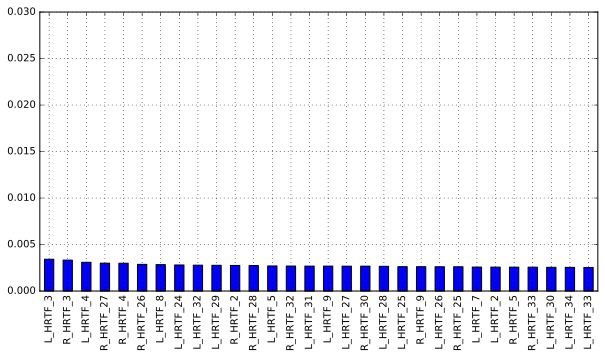

In [87]:
# More informative features
importances_e.sort_values(ascending=False, inplace=True)
importances_e[:30].plot(kind='bar', figsize=(10,5), grid=True, ylim=(0, 0.03))

In [78]:
best_azimuth = RandomForestClassifier(n_estimators=100, max_features='sqrt')
best_azimuth.fit(X_big, y_big_a.astype(np.str))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [81]:
importances_a = pd.Series(best_azimuth.feature_importances_, index=train.columns[:-3])

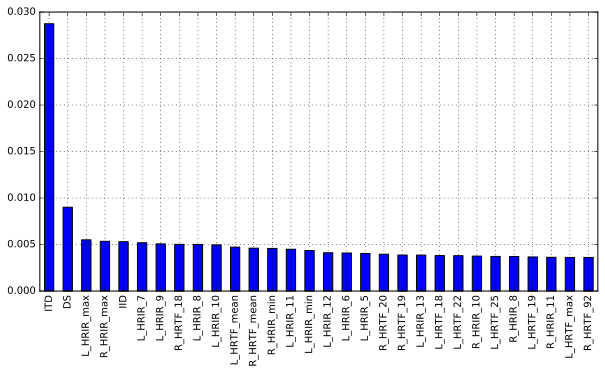

In [86]:
# More informative features
importances_a.sort_values(ascending=False, inplace=True)
importances_a[:30].plot(kind='bar', figsize=(10,5), grid=True, ylim=(0, 0.03))

In [ ]:
# Build dataframe to compare real values with predictions on test set
y_test = pd.Series(y_test_e, index=test.index)
y_pred = pd.Series(y_pred_e, index=test.index)
new_df = pd.concat([y_test, y_pred, test.ix[:, -3:]], axis=1)
new_df.to_csv('results/regtree15_all_features.csv')